# Cluster analysis of environmental variables within Luxembourg City
v0: 03.10.24, First experiments
-------------


Perform a cluster analysis of environmetal layers (DEM, wetness index, imperviousness) within the administrative area of Luxembourg city. Can we find homogeneous areas?

## Load data

In [1]:
import xarray as xr
import rioxarray as rxr
from glob import glob
import re
from src import db_connect
import os

In [ ]:
# load cube
pattern = r'\\|\.' # to get the name of the layer from the filename

path = f"{os.getenv('HOME')}/s3/data/d012_luxembourg/*.tif"
layers = glob(path)
da_dict = {}
for layer in layers:
    name = re.split(pattern, layer)[-2]
    # print(layer)
    print(name)
    da = rxr.open_rasterio(filename=layer, default_name=name) # type: ignore
    da_dict[name] = da

In [90]:
ds = xr.Dataset({
    'air_temperature_2017_month_mean_10m_b12': da_dict['air_temperature_2017_month_mean_10m_b12'],
                 'dem_2019_10m_b1': da_dict['dem_2019_10m_b1'],
                'dem_aspect_2019_10m_b1': da_dict['dem_aspect_2019_10m_b1'],
                'dem_slope_2019_10m_b1': da_dict['dem_slope_2019_10m_b1'],
                'dem_surface_model_2019_10m_b1': da_dict['dem_surface_model_2019_10m_b1'],
                'hrl_treecover_2018_10m_b1': da_dict['hrl_treecover_2018_10m_b1'],
                'pH_CaCl_10m_b1': da_dict['pH_CaCl_10m_b1'],
                'shadow_2019_10m_b1': da_dict['shadow_2019_10m_b1'],
                # 'soil_map_25000_10m_main_classes_b1': da_dict['soil_map_25000_10m_main_classes_b1'],
                'soil_nitrat_10m_b1': da_dict['soil_nitrat_10m_b1'],
                'twi_2019_10m_b1': da_dict['twi_2019_10m_b1'],
                 })
ds = ds.sel(band=1)

<xarray.Dataset>
Dimensions:                        (band: 1, x: 980, y: 1048)
Coordinates:
  * band                           (band) int32 1
  * x                              (x) float64 7.278e+04 7.278e+04 ... 8.256e+04
  * y                              (y) float64 6.96e+04 6.96e+04 ... 8.006e+04
    spatial_ref                    int32 0
Data variables:
    dem_aspect_2019_10m_b1         (band, y, x) float32 nan nan nan ... nan nan
    dem_slope_2019_10m_b1          (band, y, x) float32 nan nan nan ... nan nan
    dem_surface_model_2019_10m_b1  (band, y, x) float32 nan nan nan ... nan nan
    hrl_treecover_2018_10m_b1      (band, y, x) float64 nan nan nan ... nan nan
    pH_CaCl_10m_b1                 (band, y, x) float32 nan nan nan ... nan nan
    shadow_2019_10m_b1             (band, y, x) float32 nan nan nan ... nan nan
    soil_nitrat_10m_b1             (band, y, x) float32 nan nan nan ... nan nan
    twi_2019_10m_b1                (band, y, x) float32 nan nan nan ... nan nan

## Correlation analysis

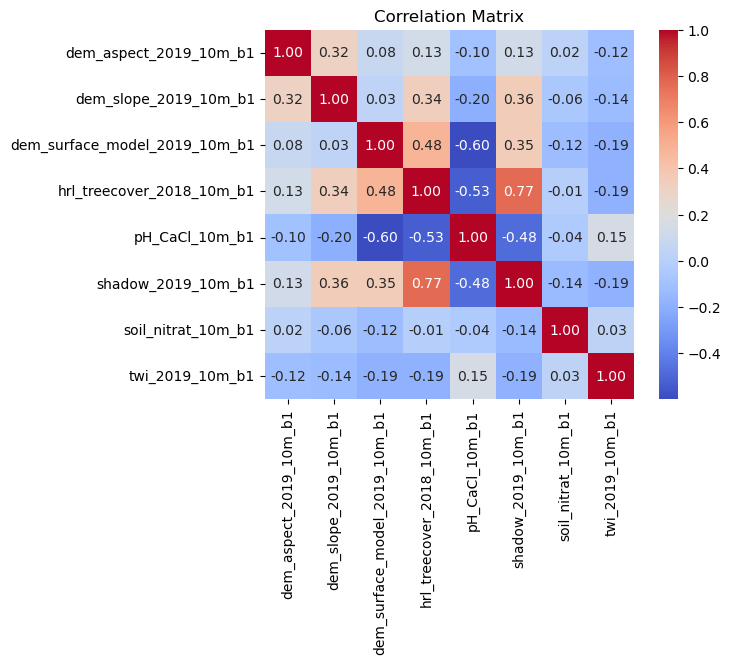

In [91]:
from matplotlib import pyplot as plt
import seaborn as sns
df = ds.squeeze().to_dataframe()
df.reset_index(inplace=True)
feature_columns = df.columns[4:]
df_features = df[feature_columns].dropna()

correlation_matrix = df[feature_columns].corr()
# plt.figure(figsize=(50, 50))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')  # Set the title of the heatmap
plt.savefig('Correlation Matrix_all.pdf', format='pdf')

## K-means clustering

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

### Normalisation

In [94]:
# MinMaxScaler alternatively, we can use StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_features = scaler.fit_transform(df_features)

### Elbow method

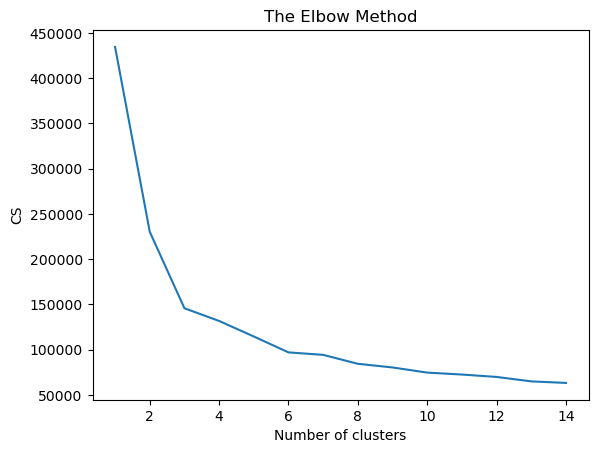

In [97]:
cs = []
max = 15
for i in range(1, max):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 0)
    kmeans.fit(normalized_features)
    cs.append(kmeans.inertia_)
plt.plot(range(1, max), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Using k = 6

In [99]:
k = 6
kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 0)
kmeans.fit(normalized_features)
print("Inertia: ", kmeans.inertia_)
print("Number of clusters: ", kmeans.n_clusters)
print("Label per Data Point: ", kmeans.labels_)

Inertia:  96950.08283929586
Number of clusters:  6
Label per Data Point:  [0 0 0 ... 4 1 1]


### add labels to xarray

In [100]:
df_features['cluster'] = kmeans.labels_
df_labels = df[['x', 'y']].merge(df_features[['cluster']], how='left', left_index=True, right_index=True)
df_labels.set_index(['x', 'y'], inplace=True)
ds_labels = df_labels.to_xarray()

In [101]:
ds_all = ds.merge(ds_labels.cluster)

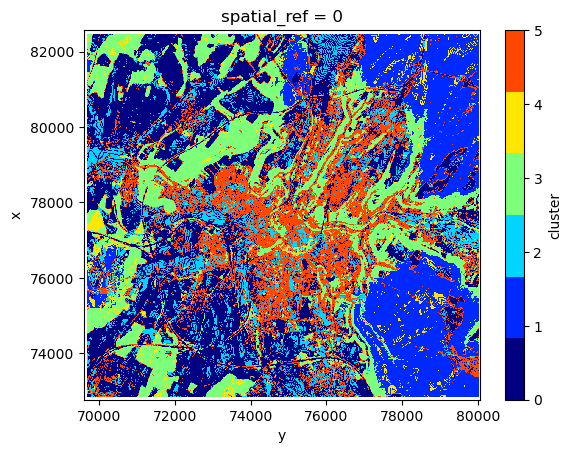

In [108]:
from matplotlib.colors import LinearSegmentedColormap
cluster_colors = [plt.cm.jet(i / float(k)) for i in range(k)]
# Create the colormap
cmap = LinearSegmentedColormap.from_list('tmp', cluster_colors, N=6)
ds_all.cluster.plot(cmap=cmap)

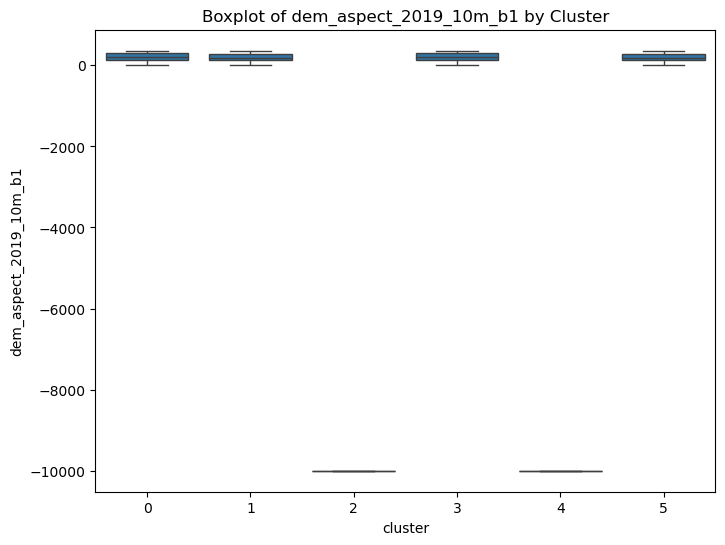

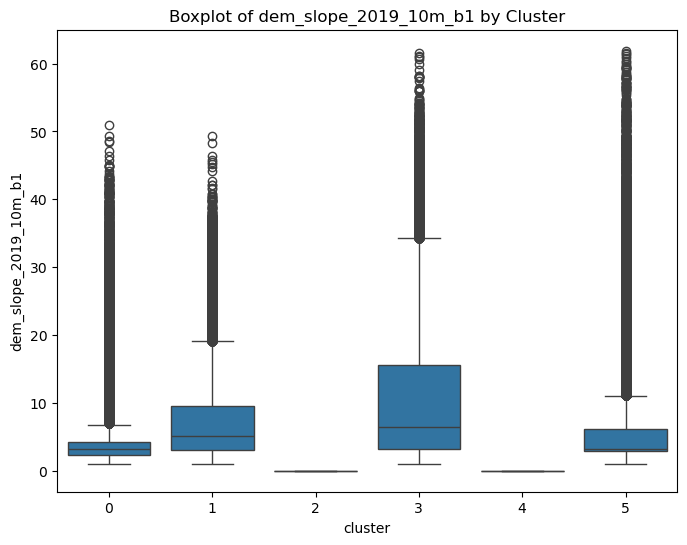

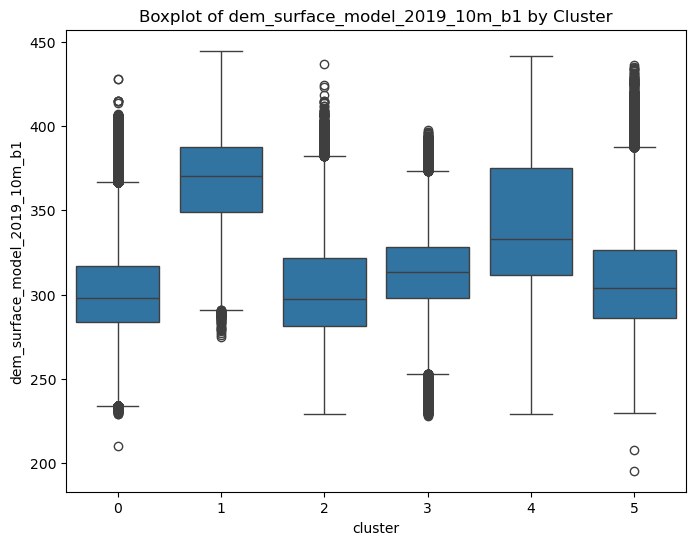

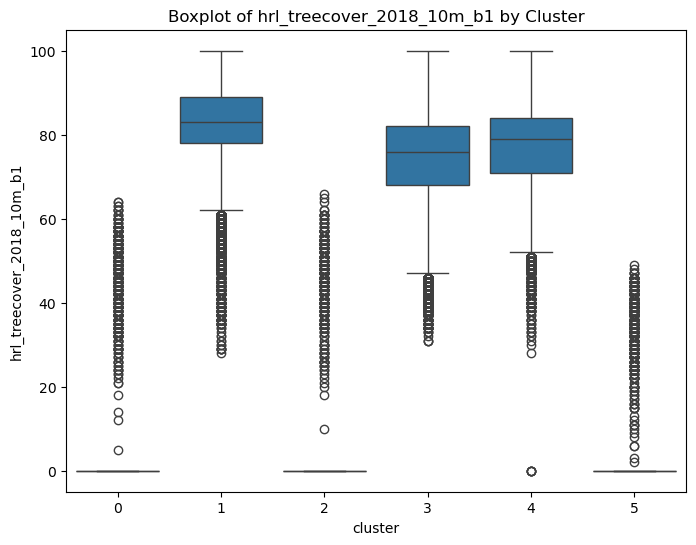

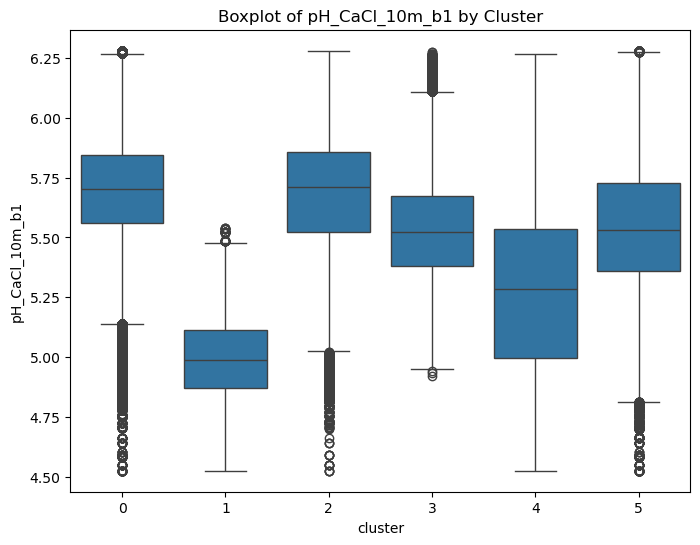

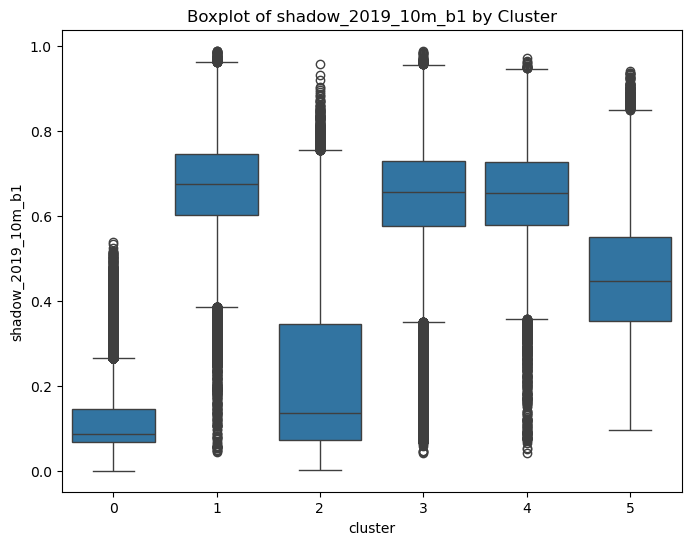

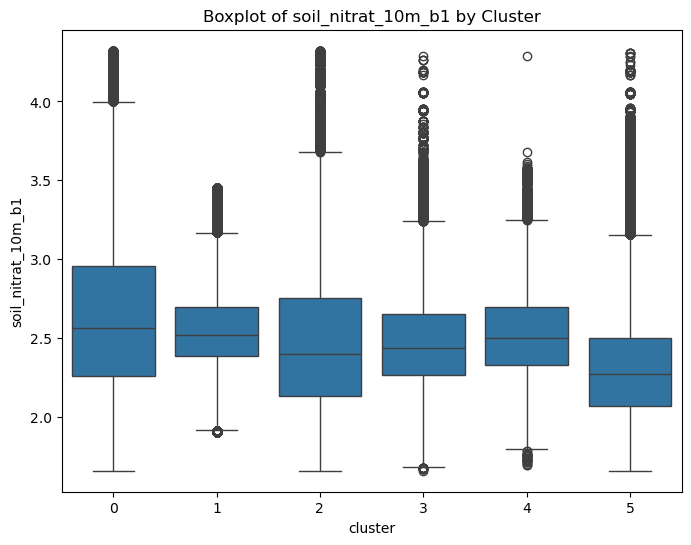

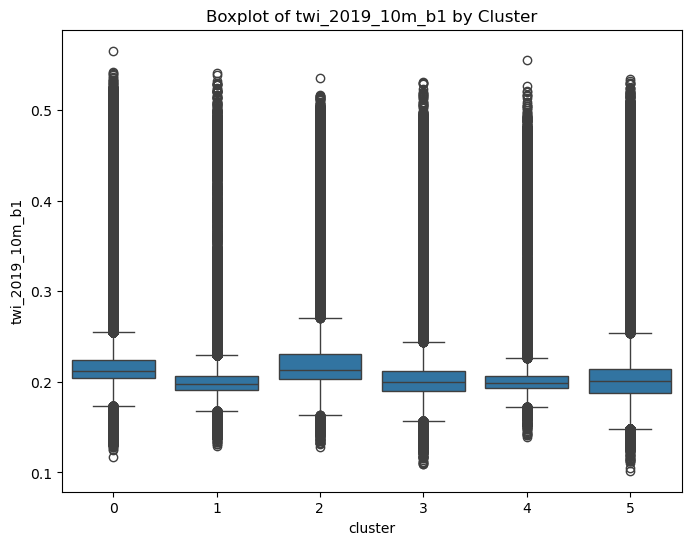

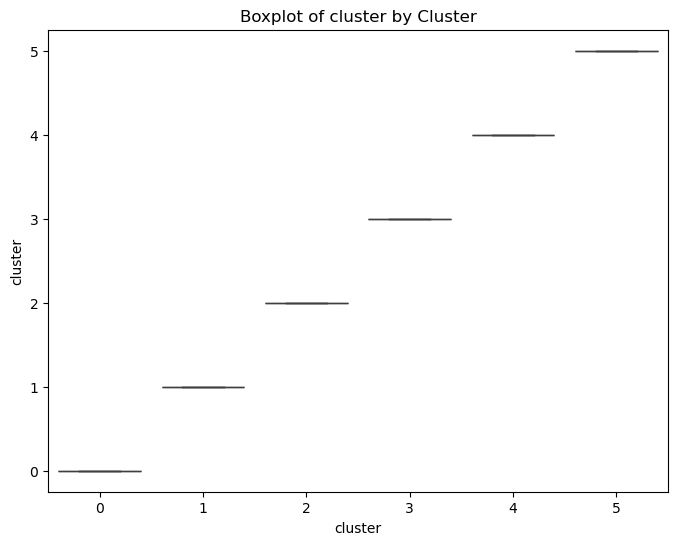

In [109]:
# Box plot of feature values within each cluster
for i in df_features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=i, data=df_features)
    plt.title(f'Boxplot of {i} by Cluster')
    # file_name = f'Boxplot of {i} by Cluster.pdf'
    # file_path = os.path.join(result_dir, file_name)
    plt.show()
    # plt.savefig(file_path, format='pdf')

In [113]:
da_to_save = ds_all.cluster.transpose('y', 'x')
da_to_save.rio.to_raster('cluster_v0.tif')